# Case Studies

In [ ]:
!pip install linearmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import seaborn as sns
from scipy.stats import norm
from datetime import datetime, timedelta
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects

In [ ]:
with open('./data/politics_users_profile_api2++PBLS.json', 'r', encoding='utf-8') as file:
    politics_users_profile = json.load(file)

special_color = "#F73A5A"
base_color = '#E0D4AE'
colors = ["#E0B531", "#DD68BA", "#9C87C6", "#70D379", "#A7457A", "#9ADECD", "#A8B1DD", "#CCD586", "#DE8C74", "#6C80E5", "#C9C9C9"]

## Visualizing PBLS and Profit/Loss

In [3]:
transactions_data = []

for user, details in politics_users_profile.items():
  if details['political_leaning_score'] != -99:
    for transaction in details['activities']:
        if transaction['slug'] == 'which-party-will-control-the-us-senate-after-the-2022-election':  # The largest one during 2022 midterm
            transactions_data.append({
                'user_id': user,
                'time': transaction['timestamp'],
                'side': transaction['side'],
                'size': transaction['size'],
                'price': transaction['price'],
                'usdcSize': transaction['usdcSize'],
                'outcome': transaction['outcome'],
                'PBLS': details['political_leaning_score']
            })

user_tx = pd.DataFrame(transactions_data)

In [5]:
user_tx['cash_flow'] = user_tx.apply(lambda x: -x['usdcSize'] if x['side'] == 'BUY' else x['usdcSize'], axis=1)
outcome_totals = user_tx.groupby(['user_id', 'outcome']).agg({'size': 'sum', 'cash_flow': 'sum'}).reset_index()

# Democratic win, final value = 1
outcome_totals['final_cash_flow'] = outcome_totals.apply(lambda x: x['size'] if x['outcome'] != 'Republican' else 0, axis=1) 
outcome_totals['total_cash_flow'] = outcome_totals['cash_flow'] + outcome_totals['final_cash_flow']

user_profit_loss = outcome_totals.groupby('user_id')['total_cash_flow'].sum().reset_index()

pbls_data = user_tx.groupby('user_id')['PBLS'].first().reset_index()
merged_data = pd.merge(user_profit_loss, pbls_data, on='user_id', how='left')

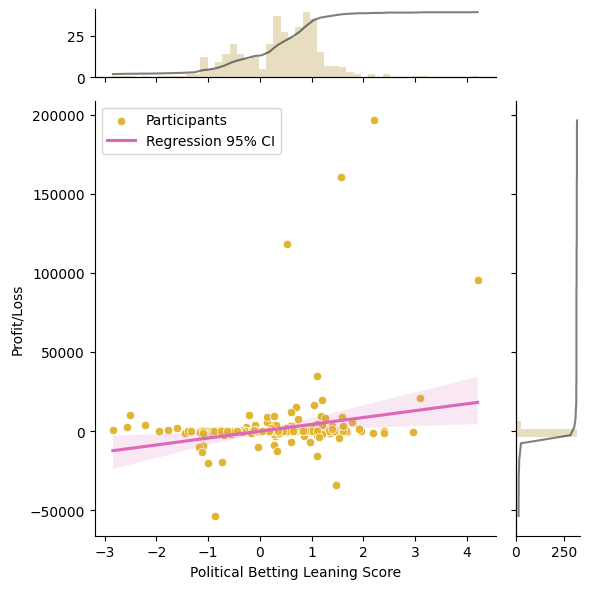

In [ ]:
x = merged_data['PBLS']
y = merged_data['total_cash_flow']

n_bins = 50

g = sns.JointGrid(x=x, y=y) #, space=0

# main
g = g.plot_joint(sns.scatterplot, alpha=1, color=colors[0])
g = g.plot_joint(sns.regplot, scatter=False, ci=95, color= colors[1])

# margin
sns.histplot(x=x, bins=n_bins, ax=g.ax_marg_x, color=base_color, edgecolor=None)
sns.histplot(y=y, bins=n_bins, ax=g.ax_marg_y, color=base_color, orientation='horizontal', edgecolor=None)

# x-cdf
cumulative_x = np.cumsum(np.histogram(x, bins=n_bins, density=True)[0])
ax_marg_x_cdf = g.ax_marg_x.twinx()
ax_marg_x_cdf.plot(np.linspace(np.min(x), np.max(x), n_bins), cumulative_x, c="black", alpha=0.5)
ax_marg_x_cdf.set_yticks([])
ax_marg_x_cdf.spines['top'].set_visible(False)
ax_marg_x_cdf.spines['right'].set_visible(False)

# y-cdf
cumulative_y = np.cumsum(np.histogram(y, bins=n_bins, density=True)[0])
ax_marg_y_cdf = g.ax_marg_y.twiny()
ax_marg_y_cdf.plot(cumulative_y, np.linspace(np.min(y), np.max(y), n_bins), c="black", alpha=0.5)
ax_marg_y_cdf.set_xticks([])
ax_marg_y_cdf.spines['top'].set_visible(False)
ax_marg_y_cdf.spines['right'].set_visible(False)

g.ax_joint.legend(['Participants', 'Regression 95% CI'], loc='upper left')
g.set_axis_labels('Political Betting Leaning Score', 'Profit/Loss')

plt.tight_layout()
plt.show()

g.fig.savefig('./figure/case_1.pdf', format='pdf', bbox_inches='tight')

## Panel Data Analysis

In [ ]:
user_tx["outcome"] = user_tx["outcome"].replace("No", "Democratic")
user_tx['time'] = pd.to_datetime(user_tx['time'], unit='s')
user_tx = user_tx.sort_values(by='time')

In [ ]:
market_start = datetime(2022, 1, 14, 00, 00, 00)
election_night = datetime(2022, 11, 8, 0, 0)
market_end = datetime(2022, 11, 14, 0, 0)

mid_point = market_start + (election_night - market_start) / 2

# Before election 1d/point, after 1d
pre_election_points = [market_start + timedelta(days=1*i) for i in range((election_night - market_start).days // 1)]


time_points = pre_election_points + [mid_point, election_night] + \
              [election_night + timedelta(days=i) for i in range(1, (market_end - election_night).days + 1)]


time_points = sorted(set(time_points))

def find_closest_transaction(transactions, time_point):
    filtered_transactions = transactions[transactions['time'] <= time_point]

    if filtered_transactions.empty:
        return None
    # closest tx
    return filtered_transactions.iloc[-1]

market_prices_at_time_points = []

for time_point in time_points:
    closest_transaction = find_closest_transaction(user_tx, time_point)

    if closest_transaction is not None:
        outcome = closest_transaction['outcome']
        price = closest_transaction['price']

        if outcome == 'Republican':
            republican_price = price
            democratic_price = 1 - price
        else:
            democratic_price = price
            republican_price = 1 - price

        market_prices_at_time_points.append({
            'time_point': time_point,
            'republican_price': republican_price,
            'democratic_price': democratic_price
        })

market_prices_df = pd.DataFrame(market_prices_at_time_points)

In [ ]:
holding_size_price_list = []

for index, row in market_prices_df.iterrows():
    time_point = row['time_point']
    rep_price = row['republican_price']
    dem_price = row['democratic_price']

    transactions_before_time = user_tx[user_tx['time'] <= time_point]

    for user_id, group in transactions_before_time.groupby('user_id'):
        rep_transactions = group[group['outcome'] == 'Republican']
        dem_transactions = group[group['outcome'] == 'Democratic']

        rep_holding_size = rep_transactions['size'].sum()
        dem_holding_size = dem_transactions['size'].sum()

        holding_size_price_list.append({
            'user_id': user_id,
            'time_point': time_point,
            'rep_holding_size': rep_holding_size,
            'republican_price': rep_price,
            'dem_holding_size': dem_holding_size,
            'democratic_price': dem_price
        })

holding_size_price_df = pd.DataFrame(holding_size_price_list)

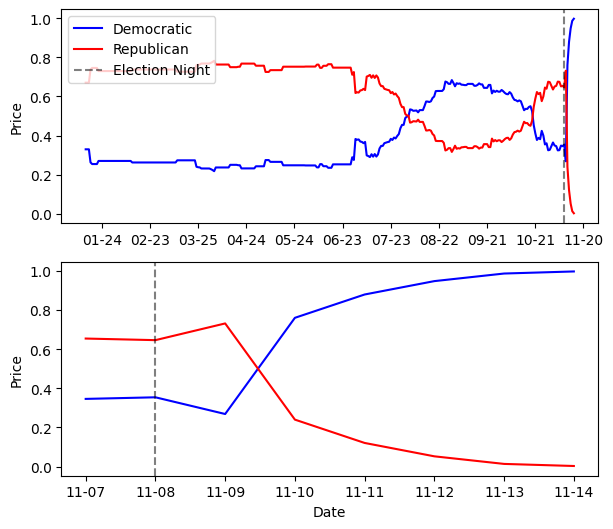

In [ ]:
market_prices_df['time_point'] = pd.to_datetime(market_prices_df['time_point'])

plt.figure(figsize=(6.25, 5.4))

# Before the election night
plt.subplot(2, 1, 1)
plt.plot(market_prices_df['time_point'], market_prices_df['democratic_price'], color='blue', label='Democratic')
plt.plot(market_prices_df['time_point'], market_prices_df['republican_price'], color='red', label='Republican')
plt.axvline(pd.to_datetime('2022-11-08'), color='black', linestyle='--', label='Election Night', alpha=0.5)
plt.legend(loc='upper left')
plt.ylabel('Price')

# Set x-axis date interval for the top subplot
ax1 = plt.gca()
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Set interval to 7 days
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# After the night
plt.subplot(2, 1, 2)
after_election_df = market_prices_df[market_prices_df['time_point'] >= pd.to_datetime('2022-11-07')]
plt.plot(after_election_df['time_point'], after_election_df['democratic_price'], color='blue', label='Democratic')
plt.plot(after_election_df['time_point'], after_election_df['republican_price'], color='red', label='Republican')
plt.axvline(election_night, color='black', linestyle='--', label='Election Night', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')

# Set x-axis date interval for the bottom subplot
ax2 = plt.gca()
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Set interval to 1 day
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.tight_layout()
plt.savefig('./case_2.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
merged_data_reset = merged_data.reset_index()
combined_df = pd.merge(holding_size_price_df, merged_data_reset[['user_id', 'PBLS']], on='user_id', how='left')
combined_df = combined_df.set_index(['user_id', 'time_point'], drop=False)
combined_df['PBLS_dem_price_interaction'] = combined_df['PBLS'] * combined_df['democratic_price']
combined_df['PBLS_rep_price_interaction'] = combined_df['PBLS'] * combined_df['republican_price']

pre_election_data = combined_df[combined_df['time_point'] < election_night].set_index(['user_id', 'time_point'])
post_election_data = combined_df[combined_df['time_point'] >= election_night].set_index(['user_id', 'time_point'])

### Total Market

In [ ]:
X = combined_df[['PBLS', 'democratic_price', 'PBLS_dem_price_interaction']]
X = sm.add_constant(X)
y = combined_df['dem_holding_size']

model = RandomEffects(y, X)
results_total_1 = model.fit()

print(results_total_1)

X = combined_df[['PBLS', 'republican_price', 'PBLS_rep_price_interaction']]
X = sm.add_constant(X)
y = combined_df['rep_holding_size']

model = RandomEffects(y, X)
results_total_2 = model.fit()

print(results_total_2)

### Before the election night

In [ ]:
X = pre_election_data[['PBLS', 'democratic_price', 'PBLS_dem_price_interaction']]
X = sm.add_constant(X)
y = pre_election_data['dem_holding_size']

model = RandomEffects(y, X)
results_bef_1 = model.fit()

print(results_bef_1)

X = pre_election_data[['PBLS', 'republican_price', 'PBLS_rep_price_interaction']]
X = sm.add_constant(X)
y = pre_election_data['rep_holding_size']

model = RandomEffects(y, X)
results_bef_2 = model.fit()

print(results_bef_1)

### After the election night

In [ ]:
X = post_election_data[['PBLS', 'democratic_price', 'PBLS_dem_price_interaction']]
X = sm.add_constant(X)
y = post_election_data['dem_holding_size']

model = RandomEffects(y, X)
results_af_1 = model.fit()

print(results_af_1)

X = post_election_data[['PBLS', 'republican_price', 'PBLS_rep_price_interaction']]
X = sm.add_constant(X)
y = post_election_data['rep_holding_size']

model = RandomEffects(y, X)
results_af_2 = model.fit()

print(results_af_2)

### Save to Latex

In [ ]:
print('\n=====total dem======\n')
print(results_total_1.summary.as_latex())
print('\n=====total rep======\n')
print(results_total_2.summary.as_latex())
print('\n=====bef dem======\n')
print(results_bef_1.summary.as_latex())
print('\n=====bef rep======\n')
print(results_bef_2.summary.as_latex())
print('\n=====af dem======\n')
print(results_af_1.summary.as_latex())
print('\n=====af rep======\n')
print(results_af_2.summary.as_latex())


=====total dem======

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                & dem\_holding\_size & \textbf{  R-squared:         }   &      0.0079      \\
\textbf{Estimator:}                    &   RandomEffects    & \textbf{  R-squared (Between):}  &      0.0219      \\
\textbf{No. Observations:}             &       22624        & \textbf{  R-squared (Within):}   &      0.0076      \\
\textbf{Date:}                         &  Thu, Mar 21 2024  & \textbf{  R-squared (Overall):}  &      0.0320      \\
\textbf{Time:}                         &      00:30:40      & \textbf{  Log-likelihood     }   &    -2.322e+05    \\
\textbf{Cov. Estimator:}               &     Unadjusted     & \textbf{                     }   &                  \\
\textbf{}                              &                    & \textbf{  F-statistic:       }   &      60.387      \\
\textbf{Entities:}                     &        373         & \textbf{  P-value            }   &      0.0000    